#### 200242V

The largest radius is 42.42640687119285 pixels in radius.
The center of the largest circle is at ( 234.0 , 0.0 ).


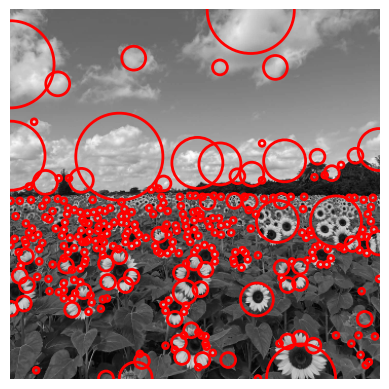

In [79]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage
from skimage.feature import blob_log

image = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

blobs_log = blob_log(gray_image, min_sigma=2, max_sigma=30, num_sigma=10, threshold=.1)
a = max(blobs_log[:, 2])
blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)
b = max(blobs_log[:, 2])
y0, x0, r = blobs_log[np.where(blobs_log[:, 2] == b)[0][0]]

fig, ax = plt.subplots()
ax.imshow(gray_image, cmap='gray')
ax.axis('off')

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

print("The largest radius is", b, "pixels in radius.")
print("The center of the largest circle is at (", x0, ",", y0, ").")
plt.show()

--------------------------------------implementing RANSAC Line---------------------------------

iteration 3
line_best_error 11.048752353791096
best_line_indices [83 51]
best_line_model [0.71614874 0.69794772 1.73682086]
no of inliers 46

iteration 11
line_best_error 6.810903051691829
best_line_indices [93 78]
best_line_model [0.70711448 0.70709909 1.429883  ]
no of inliers 41

--------------------------------------implementing RANSAC Circle---------------------------------


no of elements in X 100
no of inliers 41
remnants 59

iteration 2
best_error 4.507648382641829
best_indecies [36 15 13]
best_model [ 1.94166759  2.82745532 10.0442052 ]
no of inliers 42

iteration 26
best_error 3.626153268354524
best_indecies [27 42  4]
best_model [ 1.86471526  3.09161479 10.24184731]
no of inliers 37


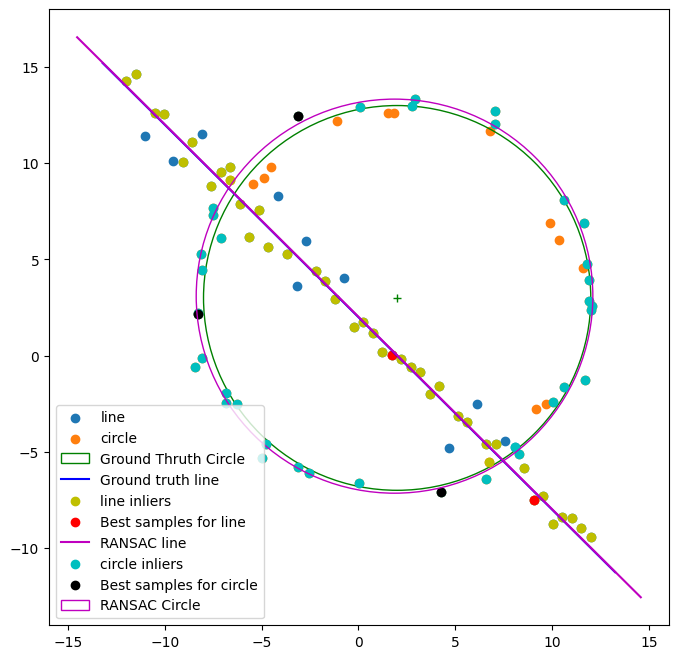

In [39]:
# Generation of a Noisy Point Set Conforming to a Line and a Circl e
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import tikzplotlib
# np . random . seed ( 0)
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace(-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # All point s
fig , ax = plt.subplots (1 ,1 , figsize=(8 ,8))
ax . scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label = 'circle')
circle_get = plt.Circle( ( x0_gt , y0_gt ) , r , color = 'g', fill=False , label='Ground Thruth Circle' )
ax . add_patch (circle_get)
ax . plot ( ( x0_gt ) , ( y0_gt ) ,'+', color = 'g' )
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot ( x_ , y_ ,color = 'b' , label= 'Ground truth line' )
plt.legend ( )


#------------------------------------------------------implementing RANSAC Line---------------------------------------------

N = X.shape[0]  # number of points
X = X # data matrix
print('--------------------------------------implementing RANSAC Line---------------------------------')

#total least square erorr for line
def line_total_error(x,line_indices):
    a,b,d = x[0],x[1],x[2]
    return np.sum(np.square(a*X[line_indices,0]+b*X[line_indices,1]-d))

#constraint
def cons(x):
    return x[0]**2+x[1]**2-1

constraint = ({'type':'eq','fun':cons})

#consensus set
def line_consensus_set(X,x,line_threshold):
    a,b,d = x[0],x[1],x[2]
    error = np.abs(a*X[:,0]+b*X[:,1]-d)
    return error<line_threshold

line_max_iterartion = 100
line_threshold = 1.
line_data_points = 0.4*N
line_best_error = np.inf
line_sample = 2

best_line_indices = []
best_line_model = []
line_inlinears = []
best_line_inliers = []   
line_iteration = 0

while line_iteration< line_max_iterartion:
    line_indices = np.random.randint(0,N,line_sample)  #randomly select s points
    x0 = np.array([1,1,0]) #initial guess
    res = minimize(line_total_error,x0=x0,args=(line_indices),tol= 1e-6,constraints=constraint) #minimize the error
    line_inlinears = line_consensus_set(X,res.x,line_threshold)  #find the consensus set
    if np.sum(line_inlinears) > line_data_points:
        x0 = res.x
        res = minimize(line_total_error, x0=x0, args=(line_inlinears),tol= 1e-6, constraints=constraint) #refit the model
        if res.fun < line_best_error:
            print('\niteration',line_iteration)
            line_best_error = res.fun
            best_line_indices = line_indices
            best_line_model = res.x
            best_line_inliers = line_inlinears
            print('line_best_error',line_best_error)
            print('best_line_indices',best_line_indices)
            print('best_line_model',best_line_model)
            print('no of inliers',np.sum(best_line_inliers))

    line_iteration+= 1

ax.scatter(X[best_line_inliers,0],X[best_line_inliers,1],color='y',label='line inliers')
ax.scatter(X[best_line_indices,0],X[best_line_indices,1],color='r',label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1]*x_ + best_line_model[2])/best_line_model[1]
plt.plot(x_, y_, color ='m', label='RANSAC line')
ax.legend()


#--------------------------------------implementing RANSAC Circle---------------------------------

print('\n--------------------------------------implementing RANSAC Circle---------------------------------')
print('\n')
print('no of elements in X',len(X))
print('no of inliers',np.sum(best_line_inliers))

line_outliers = np.where(best_line_inliers==False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('remnants',len(remnants))

def circle_tls(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

def circle_consenus_set(remnants, x, circle_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    # Count number of inliers
    return distances < circle_threshold

circle_threshold = 1.
max_circle_iterations = 100
circle_best_model = []
circle_best_inliers = []
circle_best_error = np.inf
circle_best_indecies = []
circle_iteration = 0
circle_sample =3
circle_num_data = 35

while circle_iteration < max_circle_iterations:
    circle_indicies = np.random.randint(0,len(remnants), circle_sample)
    x0 = np.array([0,0,0]) #initial guess
    res = minimize(circle_tls, x0, args=circle_indicies, tol=1e-6) #minimize the error
    circle_inliers = circle_consenus_set(remnants, res.x, circle_threshold)  #find the consensus set


    if np.sum(circle_inliers) > circle_num_data:
            x0 = res.x
            res = minimize(circle_tls, x0=x0, args=(circle_inliers),tol= 1e-6)
            if res.fun < circle_best_error:
                print('\niteration',circle_iteration)
                circle_best_error = res.fun
                circle_best_indecies = circle_indicies
                circle_best_model = res.x
                circle_best_inliers = circle_inliers
                print('best_error',circle_best_error)
                print('best_indecies',circle_best_indecies)
                print('best_model',circle_best_model)
                print('no of inliers',np.sum(circle_best_inliers))
                # best_model = res.x
                # best_inliers = inliers
                # best_indecies = indices
    circle_iteration += 1


ax.scatter(remnants[circle_best_inliers,0],remnants[circle_best_inliers,1],color='c',label='circle inliers')
ax.scatter(remnants[circle_best_indecies,0],remnants[circle_best_indecies,1],color='k',label='Best samples for circle')
circle = plt.Circle((circle_best_model[0],circle_best_model[1]),circle_best_model[2],color='m',fill=False,label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()

Image shape: (768, 1024, 3)
Flag shape: (192, 383, 3)
Selected Points: [(188, 187), (164, 495), (423, 302), (430, 515)]
Homograph matrix
 [[-1.17727877e-01  2.23317498e+00  1.88000000e+02]
 [ 6.37976191e-01  1.31948653e+00  1.87000000e+02]
 [-3.35760312e-04  2.38585495e-03  1.00000000e+00]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 767.5, -0.5)

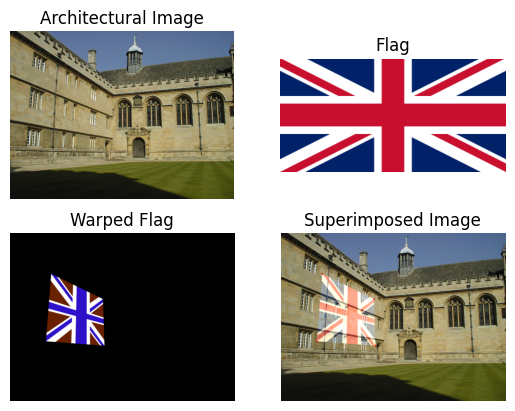

In [53]:
import cv2
import numpy as np

# Initialize a list to store the selected points
selected_points = []

# Callback function for mouse click events
def mouse_click(event, x, y, flags, param):
    global selected_points

    if event == cv2.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        cv2.circle(architectural_image, (x, y), 4, (0, 0, 255), -1)
        cv2.imshow('Image', architectural_image)




architectural_image = cv.imread('images/005.jpg')
flag = cv.imread('Flag_of_the_United_Kingdom_(1-2).svg.png')

architectural_image = architectural_image.astype(np.float32) / np.iinfo(architectural_image.dtype).max
flag = flag.astype(np.float32) / np.iinfo(flag.dtype).max

print("Image shape:", architectural_image.shape)
print("Flag shape:", flag.shape)

cv2.imshow('Image', architectural_image)
cv2.setMouseCallback('Image', mouse_click)

# Wait for the user to select four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()

print("Selected Points:", selected_points)

dst_points = np.array(selected_points).astype(np.float32)
h2, w2 = flag.shape[:2]
src_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

H = cv2.getPerspectiveTransform( src_points,dst_points) #homograph matrix
print('Homograph matrix\n',H)

flag_warped = cv2.warpPerspective(flag, H, (architectural_image.shape[1], architectural_image.shape[0]))
superimposed_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.5, 0)


plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
plt.title('Architectural Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(flag, cv.COLOR_BGR2RGB))
plt.title('Flag')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(flag_warped)
plt.title('Warped Flag')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(superimposed_image, cv.COLOR_BGR2RGB))
plt.title('Superimposed Image')
plt.axis('off')




# Question 04

((< cv2.DMatch 00000209151C56D0>, < cv2.DMatch 000002091A217EB0>), (< cv2.DMatch 000002091DD8E590>, < cv2.DMatch 000002091EB4AFD0>), (< cv2.DMatch 000002091EB48710>, < cv2.DMatch 000002091EB49C30>), (< cv2.DMatch 000002091EB4AF10>, < cv2.DMatch 000002091EB49FB0>), (< cv2.DMatch 000002091EB497D0>, < cv2.DMatch 000002091EB48F30>))


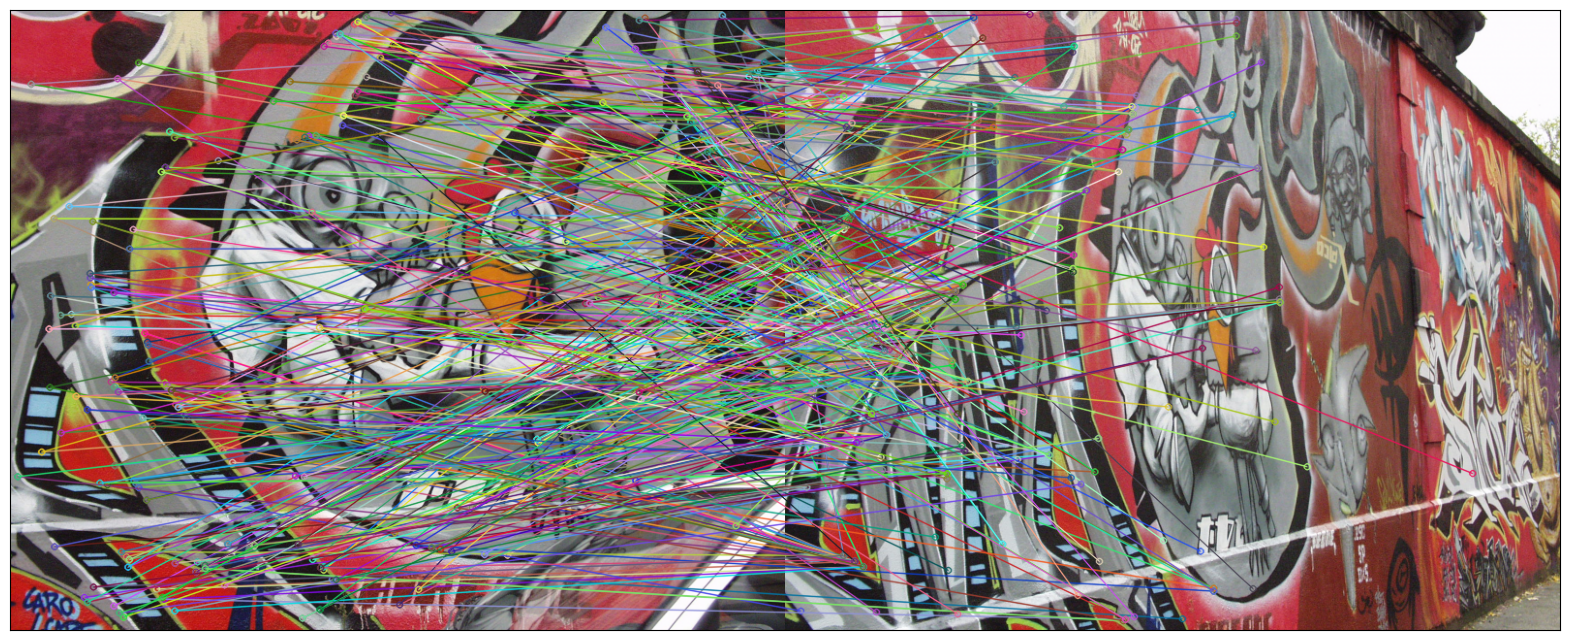

In [82]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt


img1 = cv.imread('graf/img1.ppm')
img5 = cv.imread('graf/img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
bf = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:200], img5, flags=2) #only draw best 200 matches

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()




In [89]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def findFeatures(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

def findMatches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches


def calHomography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def calDistance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


def RANSAC(corres,threshold):
    max_inliers = []
    homography = []

    #(int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4)))

    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        
        
        h = calHomography(sample)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))
               
        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = calHomography(max_inliers)
       
    return homography,max_inliers

img_lst = []
for i in range(1,6):
    img = cv.imread('graf/img'+str(i)+'.ppm')
    img_lst.append(img)


homographs = []
estimated_threshold = 100

for i in range(4):
    correspondence = []
    key1, des1 = findFeatures(img_lst[i])
    key5, des5 = findFeatures(img_lst[i+1])
    keypoints = [key1, key5]
    matches = findMatches(des1, des5)

    for match in matches:
        (x1, y1) = keypoints[0][match[0].queryIdx].pt
        (x2, y2) = keypoints[1][match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])

    corres = np.matrix(correspondence)
    H,inliers =RANSAC(corres,estimated_threshold)
    homographs.append(H)

final_homograph = homographs[3]@homographs[2]@homographs[1]@homographs[0]
final_homograph = (1/final_homograph.item(8))*final_homograph
print('Calculated Homography\n',final_homograph)
print('no of inliers',len(inliers))

print('Original Homography\n',open('graf/H1to5p').read())

Calculated Homography
 [[ 6.22687296e-01  6.64753688e-02  2.19896547e+02]
 [ 2.16759562e-01  1.14463617e+00 -1.71586629e+01]
 [ 4.89265935e-04 -4.18045527e-05  1.00000000e+00]]
no of inliers 1098
Original Homography
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



#### stiching images using calculated homography

(-0.5, 799.5, 639.5, -0.5)

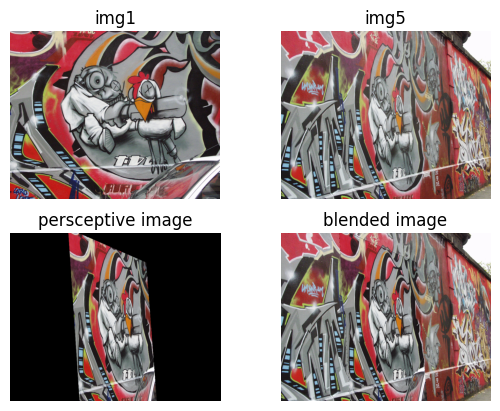

In [90]:
calculated_H = final_homograph

img1 = cv.imread('graf/img1.ppm')
img5 = cv.imread('graf/img5.ppm')
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')

image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('persceptive image')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

plt.subplot(2,2,4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB)) 
plt.title('blended image')
plt.axis('off') 


#### Stiching images using original homography

(640, 800, 3)
(640, 800, 3)


(-0.5, 799.5, 639.5, -0.5)

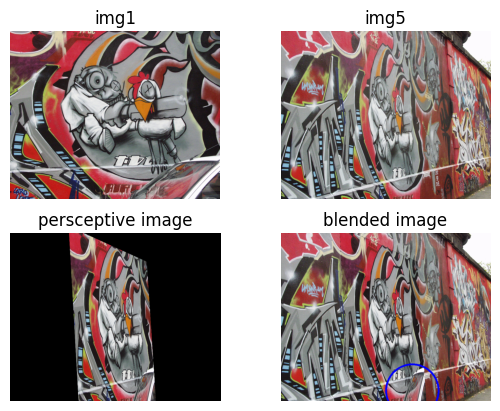

In [17]:
import cv2  as cv
import numpy as np
import matplotlib.pyplot as plt

img1 = cv.imread('graf/img1.ppm')
img5 = cv.imread('graf/img5.ppm')

plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')
print(img1.shape)
print(img5.shape)

h_text = open('graf/H1to5p','r')


#coverting h_text to homography matrix
original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)


original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('persceptive image')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
difference = cv.circle(output_image, (500, 600), 100, (0, 0, 255), 5)

#dst = cv.add(image_perspective, img5_bg)
plt.subplot(2,2,4)
plt.imshow(difference) 
plt.title('blended image')
plt.axis('off')
 



